# Retrieval Augmented Generation project for music recommendations based on Pitchfork articles.

for Natural Language Processing course 2023-2024 held by prof. G.Satta.


Ekaterina Chueva, Physics of Data, 2072050

Oksana Abramova, Data Science, 2073541
______

In this project we are building a Retrival-Augmented Generation (RAG) system in order to make an assistant for music recommendations. Streaming platforms, such as, for example, Spotify, are usually providing recommendations based on the questionnaire (e.g. "which bands do you like?") once starting using the service, history of music streaming and user's data (language, location etc). In principle, there is no direct way of influencing them. But what if we want a recommendation system with which we can chat directly? Second issue is that a user can definetely find some already done playlists on the streaming service for particular occasions ("summer 2024", "study session"), but they need to search for it by themselves.

Our big **goal** for the project is to implement a RAG system based on music reviews in order to provide a user a very straightforward way of asking for music recommenadations.
_______





In [ ]:
!pip install accelerate #after this restart the session

In [ ]:
!pip install openpyxl
!pip install seaborn

## Domain and dataset descripton


In this project as a domain we use the articles from [Pitchfork](https://pitchfork.com) - an online music publication portal. Each review on this website is written by one person (reviewer), that gives a total score for the album and analyzes its lyrics, vocals and instrumental part, usually linking it to some cultural background and previous works by particular musician.

The chosen dataset can be found on Kaggle [here](https://www.kaggle.com/datasets/timstafford/pitchfork-reviews?resource=download). This dataset is a collection of album reviews from early days of Pitchfork untill 2023 (included). The dataset contains features of different formats such us artist names, titles of the album, genre, dates, scores etc. Language of the reviews is English.

We firstly load the needed libraries and the dataset.

## Loading libraries and Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import time
import transformers
import torch
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/Colab\ Notebooks


/content/drive/MyDrive/Colab Notebooks


In [ ]:
data_all = pd.read_excel("pitchfork_reviews.xlsx", sheet_name="Result 1")

In [ ]:
data_all.head()

,artist,album,score,year,reviewer,genre,label,review_date,summary,review,best_new
0,Green-House,A Host for All Kinds of Life,7.6,2023,Hattie Lindert,Electronic / Experimental,Leaving,"October 23, 2023",The Los Angeles ambient musician continues to ...,For proof that we all must ultimately coexist ...,Not Available
1,Tkay Maidza,Sweet Justice,7.6,2023,Dylan Green,Pop/R&B,4AD,"November 3, 2023",The Australian musician chooses herself over t...,Tkay Maidza’s three-partLast Year Was WeirdEP ...,Not Available
2,A Giant Dog,Bite,6.4,2023,Linnie Greene,Rock,Merge,"August 28, 2023","On its first album in six years, the Austin gr...","A Giant Dog’sBite, the Austin, Texas, group’s ...",Not Available
3,Margaret Glaspy,Echo the Diamond,7.7,2023,Marc Hogan,Rock,ATO,"August 23, 2023","On her third album, the Brooklyn musician scra...",Margaret Glaspyhad only a couple of EPs to her...,Not Available
4,Maria BC,Spike Field,7.8,2023,Hannah Jocelyn,Rock / Experimental,Sacred Bones,"October 26, 2023","On their spectral new album, the Oakland music...","Since the 1980s, teams of engineers, anthropol...",Not Available


In [ ]:
len(data_all)

25708

As the number of data entries is relatively large, we limit the dataset to the articles from 2022-2023. So the overall result in principle should lead to a recommendation of an album of recent years.

We are also not interested in particular review date (only album's year), reviewer's name, 'best_new' column and label's name, which we drop from the datatset.

The cleaned version of the data we then save to a csv file that will be later loaded via LangChain's csv loader.

In [ ]:
# clean the data from points that have no information about the publication year, drop some columns
index_no_year = data_all[(data_all['year'] == 'Not Available')].index
data_all.drop(index_no_year, inplace=True)
data_all.drop(columns=['reviewer', 'label', 'best_new', 'review_date'], inplace = True)
data_all.head()

,artist,album,score,year,genre,summary,review
0,Green-House,A Host for All Kinds of Life,7.6,2023,Electronic / Experimental,The Los Angeles ambient musician continues to ...,For proof that we all must ultimately coexist ...
1,Tkay Maidza,Sweet Justice,7.6,2023,Pop/R&B,The Australian musician chooses herself over t...,Tkay Maidza’s three-partLast Year Was WeirdEP ...
2,A Giant Dog,Bite,6.4,2023,Rock,"On its first album in six years, the Austin gr...","A Giant Dog’sBite, the Austin, Texas, group’s ..."
3,Margaret Glaspy,Echo the Diamond,7.7,2023,Rock,"On her third album, the Brooklyn musician scra...",Margaret Glaspyhad only a couple of EPs to her...
4,Maria BC,Spike Field,7.8,2023,Rock / Experimental,"On their spectral new album, the Oakland music...","Since the 1980s, teams of engineers, anthropol..."


In [ ]:
data = data_all[data_all['year'].astype(int) >= 2022].copy().reset_index(drop='index')
data.head()

,artist,album,score,year,genre,summary,review
0,Green-House,A Host for All Kinds of Life,7.6,2023,Electronic / Experimental,The Los Angeles ambient musician continues to ...,For proof that we all must ultimately coexist ...
1,Tkay Maidza,Sweet Justice,7.6,2023,Pop/R&B,The Australian musician chooses herself over t...,Tkay Maidza’s three-partLast Year Was WeirdEP ...
2,A Giant Dog,Bite,6.4,2023,Rock,"On its first album in six years, the Austin gr...","A Giant Dog’sBite, the Austin, Texas, group’s ..."
3,Margaret Glaspy,Echo the Diamond,7.7,2023,Rock,"On her third album, the Brooklyn musician scra...",Margaret Glaspyhad only a couple of EPs to her...
4,Maria BC,Spike Field,7.8,2023,Rock / Experimental,"On their spectral new album, the Oakland music...","Since the 1980s, teams of engineers, anthropol..."


Now we can have a look at the descriptive statistics of the dataset.

### 1) Number of data entries

In [ ]:
print(len(data))

1814


### 2) Distribution and statistical description of the reviews' lengths in characters.

Text(0, 0.5, 'Frequency')

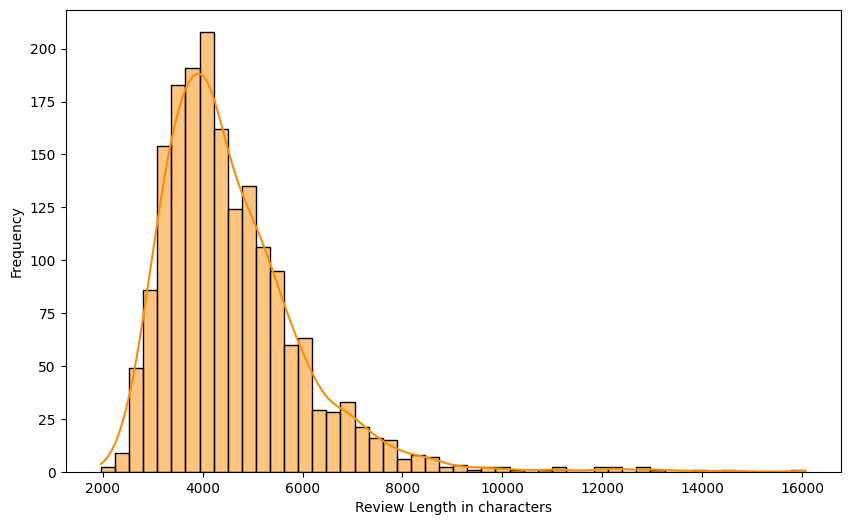

In [ ]:
data['review_length'] = data['review'].str.len()

plt.figure(figsize=(10, 6))
sns.histplot(data['review_length'], kde=True, bins=50, color='darkorange')
plt.xlabel('Review Length in characters')
plt.ylabel('Frequency')

In [ ]:
print(data["review_length"].describe())

count     1814.000000
mean      4578.545204
std       1434.384655
min       1966.000000
25%       3614.250000
50%       4262.000000
75%       5208.000000
max      16062.000000
Name: review_length, dtype: float64


### 3) Distribution of published articles throughout the years

Text(0, 0.5, 'Frequency')

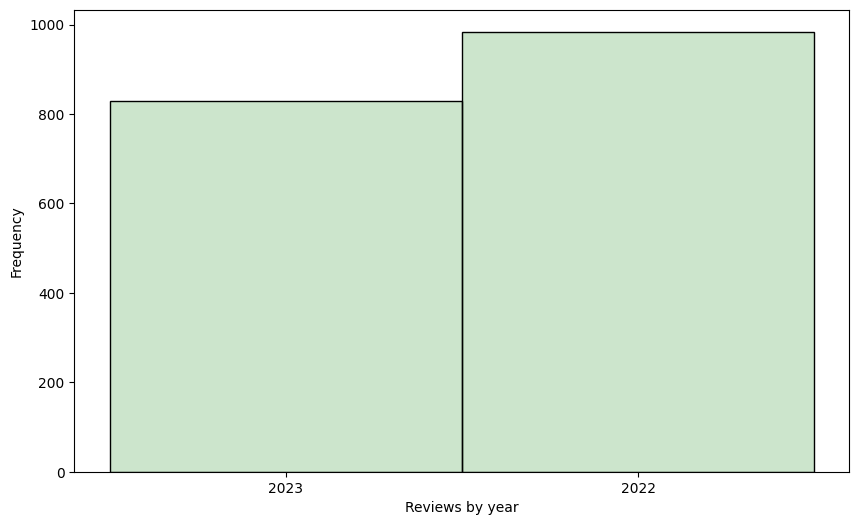

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data['year'], bins=5, color='green', alpha=0.2)
plt.xlabel('Reviews by year')
plt.ylabel('Frequency')

### 4) Distribution by music


As it can be seen from the plot below, the two most popular genre of albums considered in reviews are Pop/R&B, Rap and Rock.

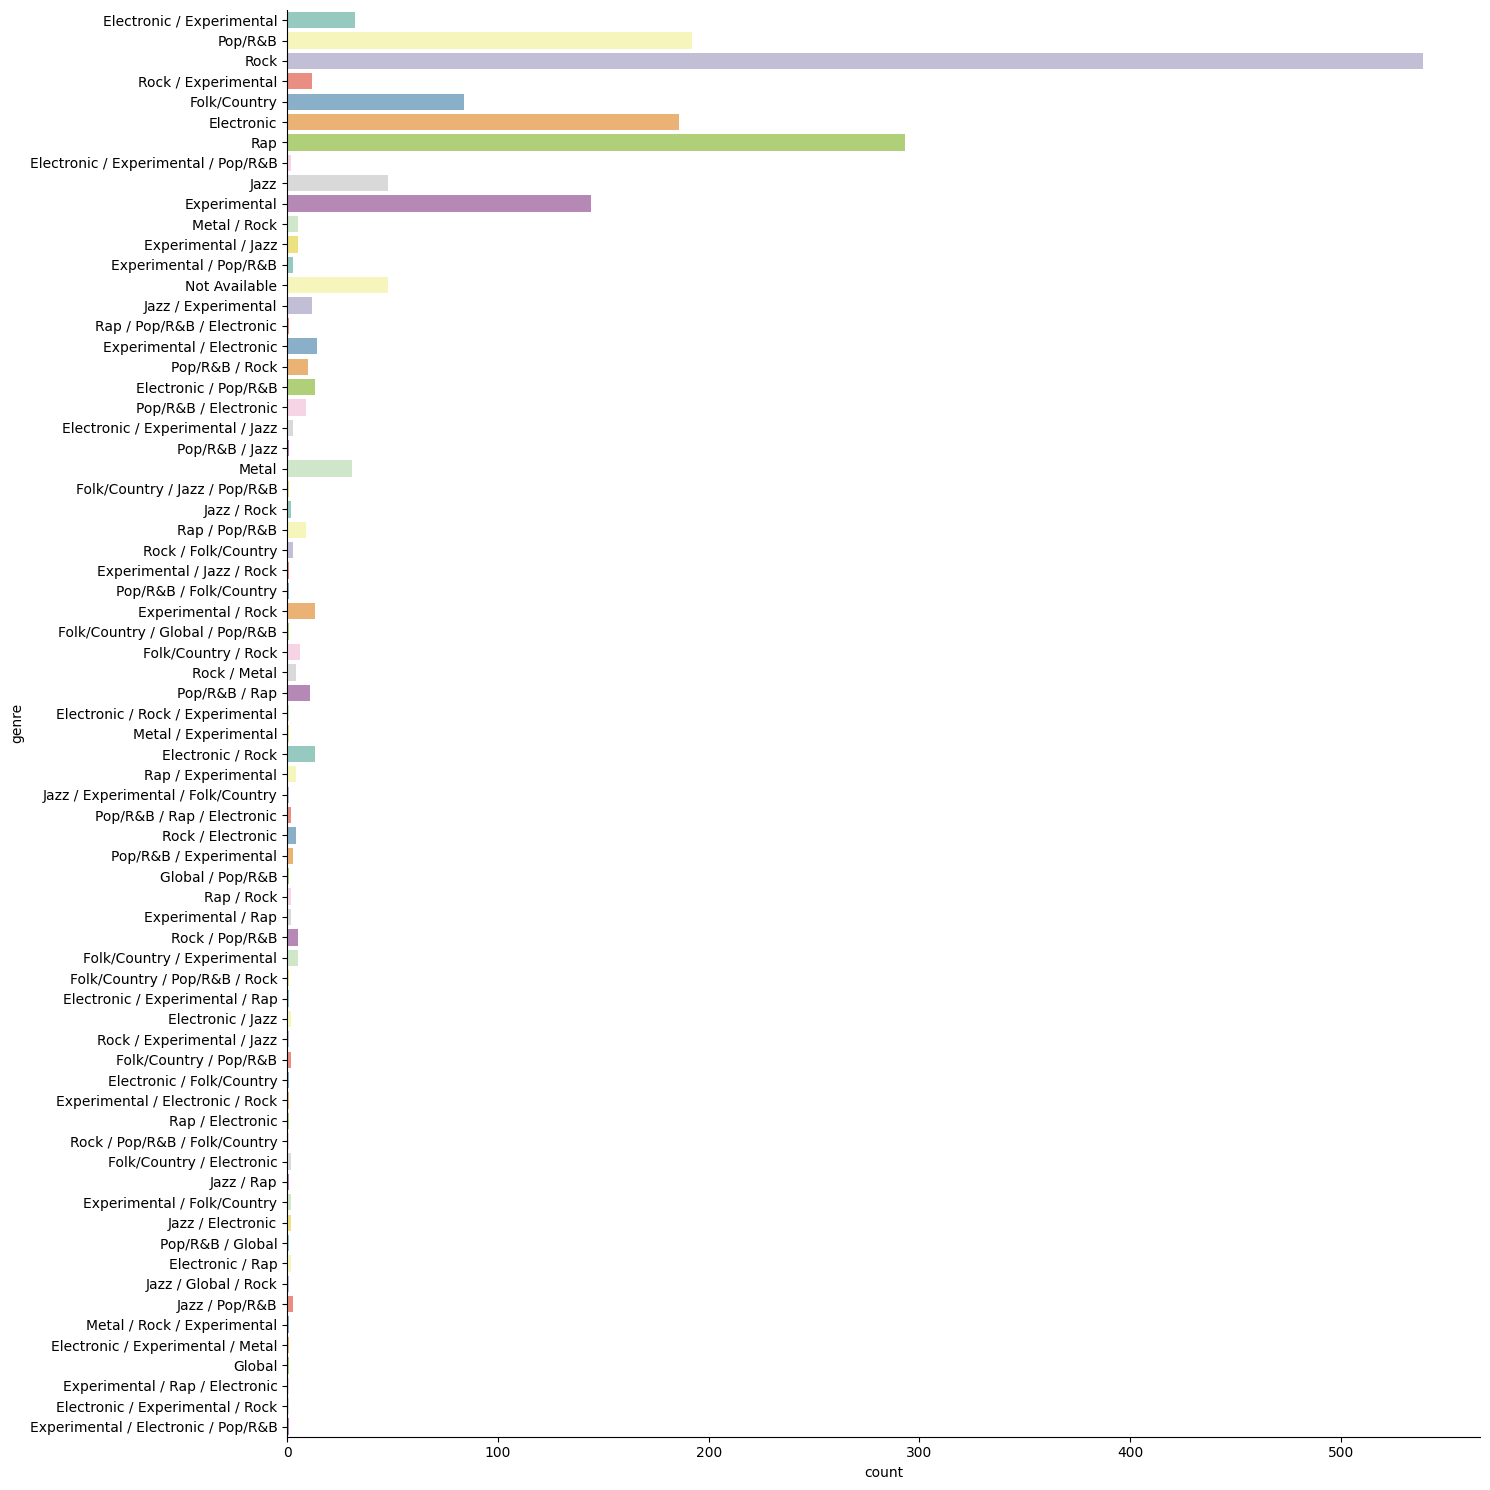

In [ ]:
sns.catplot(data=data, y="genre", kind="count", height = 15, hue = 'genre', palette='Set3')

### 5) Number of words per article

For this and the folllowing description we use library TextBlob - a library for processing textual data.

In [ ]:
from textblob import TextBlob
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Text(0, 0.5, 'Frequency')

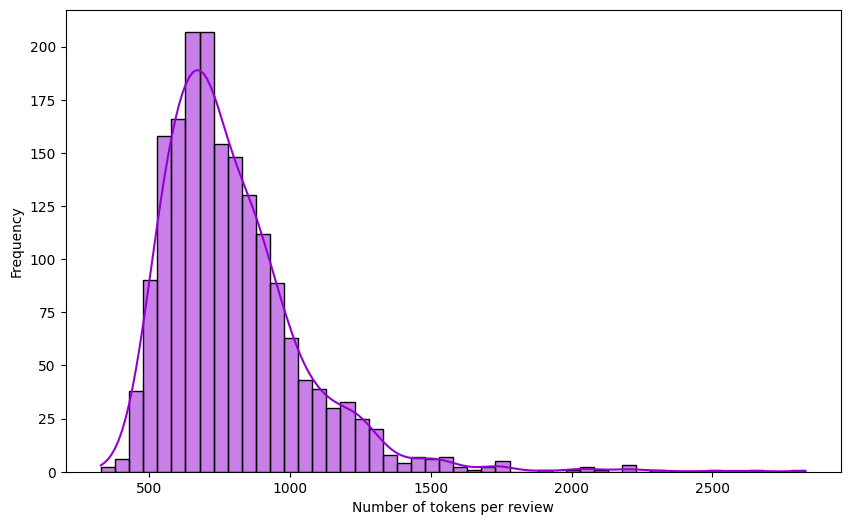

In [ ]:
data['num_tokens'] = data['review'].apply(lambda text: len(TextBlob(text).words))

plt.figure(figsize=(10, 6))
sns.histplot(data['num_tokens'], kde=True, bins=50, color='darkviolet')
plt.xlabel('Number of tokens per review')
plt.ylabel('Frequency')

### 6) Sentiment analysis of each article

Using TextBlob's sentiment analysis tool, we want to see if Pitchfork articles

a) are positive/negative. For this we use value "polarity", which lies in[-1, 1], -1 means negative and 1 means postive sentiment

b) are subjective. For this we use value "subjectivity", which lies in [0, 1], the higher the value, the more subjective review is. Subjectivity parameter shows the amount of personal opinion and factual information contained in the text.

In [ ]:
data['polarity'] = data['review'].apply(lambda text: TextBlob(text).sentiment[0] )

In [ ]:
data['subjectivity'] = data['review'].apply(lambda text: TextBlob(text).sentiment[1] )

<Axes: xlabel='subjectivity', ylabel='Count'>

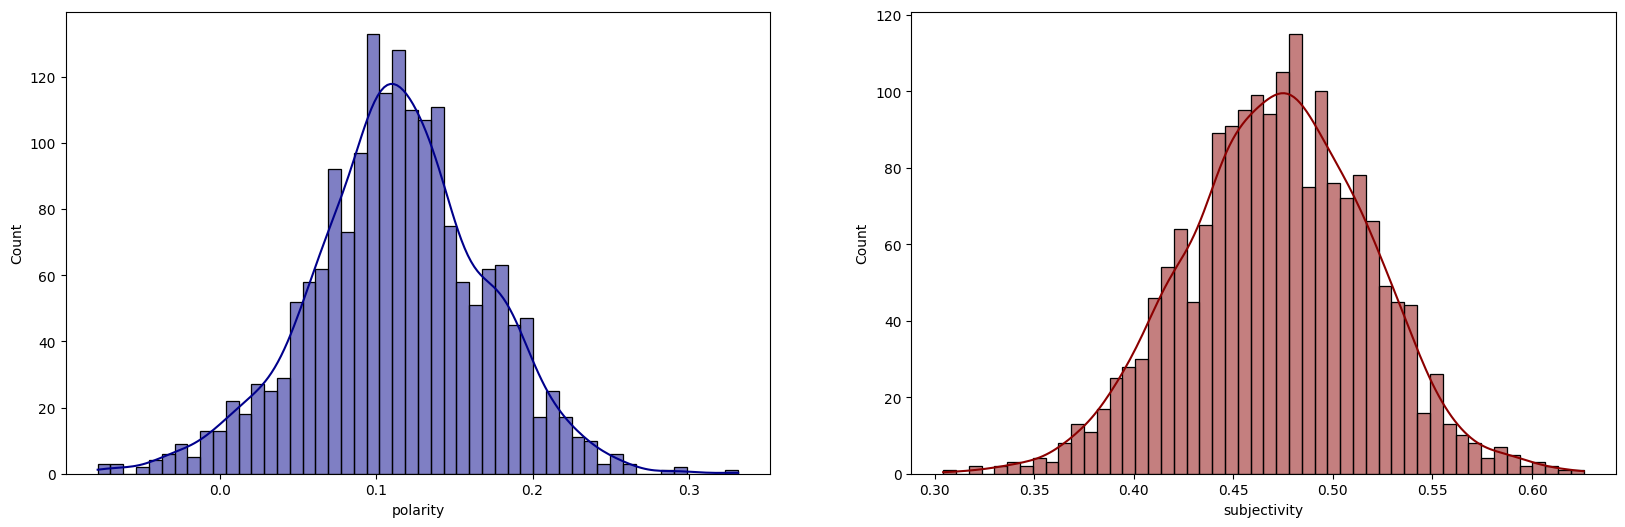

In [ ]:
fig, axes = plt.subplots(1, 2)
fig.set_figheight(6)
fig.set_figwidth(20)

sns.histplot(data['polarity'], kde=True, bins=50, color='darkblue', ax=axes[0])
sns.histplot(data['subjectivity'], kde=True, bins=50, color='darkred', ax=axes[1])

As we can see, the positive/negative reviews are well-balanced with a small bias towards postivity. Moreover, reviews contain facts and personal opinions mostly in 50/50 proportion.

Finally, we save the dataset from selected years to a different file, which later will be used as documents for retrieval in our RAG system.

In [ ]:
# save the cleaned version of data to a csv file for a later use
data.drop(columns=['review_length', 'num_tokens', 'polarity', 'subjectivity'], inplace = True)
data.to_csv('reviews.csv', index=False)

## Adding embedding model

We are using LangChain library - a framework designed for developing applications that leverage the power of large language models. This library provides tools and abstractions to enhance customization, accuracy and relevance of generated information.

Components of the library that are particularily useful for our project:


*   **Embedding models** create a vector representation of a piece of text.
*   **Vector stores** that store embedded data and performing vector search for you.
*   **Retrievers** are interfaces that returns documents given an unstructured query. It is more general than a vector store. A retriever does not need to be able to store documents, only to return (or retrieve) them.
*   **Text splitters**. LangChain has a number of built-in document transformers that make it easy to split, combine, filter, and otherwise manipulate documents.
*   **Prompt templates** help to translate user input and parameters into instructions for a language model

There are a number of useful components and methods of the LangChain llibrary some of them are used later. So we start this part with importing everything that is needed.








### 1) Separating initial data into chunks

In [ ]:
!pip install langchain
!pip install  -U langchain-community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.6/983.6 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.1/366.1 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 7.8 MB/s eta 0:00:00


In [ ]:
from langchain.embeddings import CacheBackedEmbeddings, HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.storage import LocalFileStore
from langchain.chains import ConversationalRetrievalChain
from langchain.llms import HuggingFacePipeline
from langchain.document_loaders.csv_loader import CSVLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain import PromptTemplate

In [ ]:
reviews = CSVLoader(file_path="reviews.csv")

rev_data = reviews.load()

print("Number of reviews:", len(rev_data))

Number of reviews: 1814


Since we work with long documents, we need to split them into chunks but to keep semantically related parts of texts together. For that, we use text splitters, that work like this:

1.   Split the text up into small, semantically meaningful chunks
2.   Start combining these small chunks into a larger chunk until you reach a certain size
3. Once you reach that size, make that chunk its own piece of text and then start creating a new chunk of text with some overlap to keep context between chunks

In this step we adjust chunk size to a value, which will lead to a manageable processing time on a vector_store creation.

1) chunk_size variable corresponds to the number of characters in a chunk.

2) chunk_overlap variable is in charge of correlaton between chunks

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

split = RecursiveCharacterTextSplitter(
    chunk_size = 9000,
    chunk_overlap = 200,
    length_function = len
)

rev_docs = split.transform_documents(rev_data)

print("Number of documents:", len(rev_docs))

Number of documents: 1860


In [ ]:
!pip install -q -U faiss-cpu tiktoken sentence-transformers

In [ ]:
!pip install tf-keras

In [ ]:
!pip install -U langchain-huggingface

### 2) Choosing the embedding model

In this section, we consider three sentence-transformers model models from HuggingFace:

- **all-MiniLM-L6-v2**: maps sentences & paragraphs to a 384 dimensional dense vector space and can be used for tasks like clustering or semantic search
- **multi-qa-MiniLM-L6-dot-v1**: maps sentences & paragraphs to a 384 dimensional dense vector space and was designed for semantic search. It has been trained on 215M (question, answer) pairs from diverse sources
- **paraphrase-MiniLM-L6-v2**: t maps sentences & paragraphs to a 384 dimensional dense vector space and can be used for tasks like clustering or semantic search


We create vector store, which will be used for similarity search, using FAISS index. FAISS is a library developed by Facebook specifically for efficient similarity search.

CacheBackedEmbeddings flow helps to prevent re-embedding quaries over and over again.

In order to avoid processing the model every time we run the script, we implemented a caching mechanism. It saves the embeddings to a local storage (disk) after they have been computed for the first time. Upon subsequent runs, it checks if the embeddings are already cached and load them instead of recomputing them.

We will evaluate the models based on time each one takes and quality of the retrieved information on the final results of our model


In [ ]:
models = {
    'all-MiniLM-L6-v2': 'sentence-transformers/all-MiniLM-L6-v2',
    'multi-qa-MiniLM-L6-dot-v1': 'sentence-transformers/multi-qa-MiniLM-L6-dot-v1',
    'paraphrase-MiniLM-L6-v2': 'sentence-transformers/paraphrase-MiniLM-L6-v2',
}

def select_model(m_key):
    if m_key not in models:
        raise ValueError(f'Model key is not found')
    m_id = models[m_key]
    return HuggingFaceEmbeddings(model_name = m_id)

def gen_emb_store(rev_docs, m_key, cache_dir = './cache'):
    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)

    cache_file = os.path.join(cache_dir, f'{m_key}_embeddings.pickle')

    if os.path.exists(cache_file):
        print(f'Loading embedding from cache: {cache_file}')
        with open(cache_file, 'rb') as f:
            vector_store = pickle.load(f)
        embed_model = select_model(m_key)
    else:
        print(f'Generating embeddings for model: {m_key}')
        store = LocalFileStore(cache_dir)
        embed_model = select_model(m_key)
        embedder = CacheBackedEmbeddings.from_bytes_store(
            embed_model, store, namespace = m_key
        )
        vector_store = FAISS.from_documents(rev_docs, embedder)

        with open(cache_file, 'wb') as f:
            pickle.dump(vector_store, f)
        print(f'Embeddings saved to cache: {cache_file}')

    return vector_store, embed_model

def compare_models(rev_docs, models, cache_dir='./cache'):
    results = {}
    for m_key in models:
        print(f'Processing model: {m_key}')
        vector_store, embedder = gen_emb_store(rev_docs, m_key, cache_dir)
        if vector_store is None:
            raise ValueError(f"Vector store creation failure for {m_key}")

        results[m_key] = (vector_store, embedder)
    return results


We use small sample of the dataset in order to estimate the time needed for processing the whole dataset by each embedding model. On this step chunk_size parameter was adjusted.

In [ ]:
sample_docs = rev_docs[:100]

def time_for_m(m_key, docs):
    start_time = time.time()
    gen_emb_store(docs, m_key)
    end_time = time.time()
    return end_time - start_time

num_docs = len(rev_docs)
sample_size = len(sample_docs)

for m in models:
    time_taken = time_for_m(m, sample_docs)
    print(f"Time taken for {m}: {time_taken} seconds")
    est_time_per_m = (time_taken / sample_size) * num_docs
    print(f"Estimated time for {m} on full dataset: {est_time_per_m} seconds")

Generating embeddings for model: all-MiniLM-L6-v2


/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embeddings saved to cache: ./cache/all-MiniLM-L6-v2_embeddings.pickle
Time taken for all-MiniLM-L6-v2: 58.81519842147827 seconds
Estimated time for all-MiniLM-L6-v2 on full dataset: 1093.962690639496 seconds
Generating embeddings for model: multi-qa-MiniLM-L6-dot-v1


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/8.49k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embeddings saved to cache: ./cache/multi-qa-MiniLM-L6-dot-v1_embeddings.pickle
Time taken for multi-qa-MiniLM-L6-dot-v1: 39.88140678405762 seconds
Estimated time for multi-qa-MiniLM-L6-dot-v1 on full dataset: 741.7941661834717 seconds
Generating embeddings for model: paraphrase-MiniLM-L6-v2


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embeddings saved to cache: ./cache/paraphrase-MiniLM-L6-v2_embeddings.pickle
Time taken for paraphrase-MiniLM-L6-v2: 11.728409051895142 seconds
Estimated time for paraphrase-MiniLM-L6-v2 on full dataset: 218.14840836524962 seconds


In [ ]:
results = compare_models(rev_docs, models.keys(), cache_dir='./cache')

Processing model: all-MiniLM-L6-v2
Loading embedding from cache: ./cache/all-MiniLM-L6-v2_embeddings.pickle


/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10

Processing model: multi-qa-MiniLM-L6-dot-v1
Loading embedding from cache: ./cache/multi-qa-MiniLM-L6-dot-v1_embeddings.pickle
Processing model: paraphrase-MiniLM-L6-v2
Loading embedding from cache: ./cache/paraphrase-MiniLM-L6-v2_embeddings.pickle


Here we output 3-best documents retrieved by each of all three models.
Based on the user's query it responses with 3 closest neigbouring embeddings.

In [ ]:
def get_closest(vector_store, embedder, query, k=3):
    q_embed = embedder.embed_query(query)
    return vector_store.similarity_search_by_vector(q_embed, k=k) #, distances=[], labels=[])

In [ ]:
query = 'What album is good for a heartbreak?'

comparisons = {}
for m_key, (vector_store, embedder) in results.items():
    close = get_closest(vector_store, embedder, query)
    comparisons[m_key] = close

for m_key, close in comparisons.items():
    print(f"Model: {m_key}")
    for n in close:
        print(n)
    print("---------------------------------------- \n")

Model: all-MiniLM-L6-v2
page_content='artist: Broken Social Scene
album: Old Dead Young: B-Sides & Rarities
score: 6.8
year: 2022
genre: Rock
summary: The Canadian indie rock band sorts through a largely subdued grab bag of material on this career-spanning set, highlighted by offbeat experiments and homespun, intimate moments.
review: Broken Social Scenehave been soundtracking intimatefirstssince the internet was a little baby and made a lot of noise when you turned it on. For over two decades, the Canadian collective has written anthemic, heart-on-your-sleeve indie rock songs that make you want to sit on your crush’s lap at a house party or shotgun a beer in a cornfield. For fans of a certain age, their work has become synonymous with being a teen:Lordeis one of those fans, and she memorably interpolated“Lover’s Spit” into “Ribs,” making an adolescent anthem of her own.Old Dead Young,the band’s new career-spanning B-sides and rarities collection, won’t necessarily give you the same ec

Based on the documents retrieved and the time it has taken to process, we proceed with the first model: **all-MiniLM-L6-v2**.

## Adding LLM and a building retrieval chain

### 1) Setting a pipeline for a LLM

In [ ]:
!pip install bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 5.3 MB/s eta 0:00:00


In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: read).

As a large language model, we select a Llama2 model with 7 billion parameters developed by Meta AI, which is available for free in the HuggingFace.

We use a version compatible with transformers.pipeline.

We need quantization in order to use this model in Google Colab, for which we select bitsandbytes library.

In [ ]:
llm_model = 'meta-llama/Llama-2-7b-chat-hf'
bnb_config = transformers.BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type='nf4',
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=torch.bfloat16
    )


model_config = transformers.AutoConfig.from_pretrained(llm_model)


model = transformers.AutoModelForCausalLM.from_pretrained(
        llm_model,
        config=model_config,
        quantization_config=bnb_config,
        trust_remote_code=True,
        device_map='auto'
    )

tokenizer = transformers.AutoTokenizer.from_pretrained(llm_model)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

We now set a pipline, where we specify the task (text generation) and set two parameters:

- temperature, which influence the model behaviour (more creative or more restricted). Since we want to build a RAG system, we set temperature to a low value.

- max_new_tokens - maximum number of tokens the LLM can return

In [ ]:
generate_text = transformers.pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    return_full_text=True,
    temperature=0.01,
    max_new_tokens=250
)

In [ ]:
from langchain.llms import HuggingFacePipeline

llm = HuggingFacePipeline(pipeline=generate_text)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFacePipeline`.
  warn_deprecated(


As retriver, we set results of one of the embedding models discussed in the previous section in order to access the results of the language model.


In [ ]:
retriever = results['all-MiniLM-L6-v2'][0].as_retriever()

### 1) Prompt template engineering

We define a prompt template to use for each query in order to force the LLM to answer user's questions correctly.

A prompt is a piece of text that we provide to the LLM in order to make its outputs conditioned to rules and data we want. Here we report all the steps:

1. Most importantly, we make a room for the user's question in {question} variable. The input query will take place in this part of the prompt.
2. Second important step is that as we are building RAG, we want the LLM provide answers based on the data we inject to it. For this reason we are adding a line with a sentence "Answer the user's question using the following context." and provide a room for our documents (vector store) in {context} variable.
3. Rule 1) is placed into the prompt because if absent, the LLM starts to generate long outputs with too many details, but we want our system to provide short answers, focusing on the most important aspects. And also because nobody wants to read a long answer to a short question. We ask it to base the choice on some specific aspects of music as well.
4. Rule 2) is an extra constraint to forse the LLM to base its recommendation on the specific knowledge (our dataset). We don't want it to make its own recommendations based on the pre-training, though it surely contains some information about musicians and still can give a recommendation/answer user's question; but most probably it will be very general.
5. We add rule 3), because we want to show to the user what to expect from the provided recommendation. Some people use Pitchfork website for finding new music that they have never heard of, so it is probable that the system's generated recommendation will not be known to them. Providing an album's genre is a good way of giving a user an idea of what is the answer right at the moment of reading it.
6. We add rule 4) as an extra constraint for LLM to prevent undesired creativity.



In [ ]:
prompt_template = """
User question: {question}

Answer the user's question using the following context.

Follow these rules in order to answer the user's question:
1) Your answer should be short (maximum 3 short sentences). Base your answer on instrumentals, vocals and album's theme.
2) Your recommendations should consist only of albums provided in the relevant information.
3) If you suggest an album, provide its genre.
4) If you cannot recommend anything from the relevant information list, just say "I don't know".

Context:
{context}

Your answer:
"""

prompt = PromptTemplate(template = prompt_template, input_variables=["question", "context"])

### 2) Building a Conversational Retrival Chain and testing it on queries

Finally, we define the retrieval chain and can test the RAG system on the following queries.

In [ ]:
from langchain.chains import ConversationalRetrievalChain

qa = ConversationalRetrievalChain.from_llm(
    llm,
    #verbose=True,
    retriever=retriever,
    combine_docs_chain_kwargs={"prompt": prompt},
    return_source_documents=True,
)

In [ ]:
query = "Which album is good for a party?"
result = qa({"question": query, "chat_history": []})
print(result['answer'])

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(



User question: Which album is good for a party?

Answer the user's question using the following context.

Follow these rules in order to answer the user's question:
1) Your answer should be short (maximum 3 short sentences). Base your answer on instrumentals, vocals and album's theme.
2) Your recommendations should consist only of albums provided in the relevant information.
3) If you suggest an album, provide its genre.
4) If you cannot recommend anything from the relevant information list, just say "I don't know".

Context:
artist: Broken Social Scene
album: Old Dead Young: B-Sides & Rarities
score: 6.8
year: 2022
genre: Rock
summary: The Canadian indie rock band sorts through a largely subdued grab bag of material on this career-spanning set, highlighted by offbeat experiments and homespun, intimate moments.
review: Broken Social Scenehave been soundtracking intimatefirstssince the internet was a little baby and made a lot of noise when you turned it on. For over two decades, the C

**Evaluation**:

We listened to this album, it is suitable enough for listening on the background while gathering, though it will fit more rock fans than others. Overall, it is not a bad recommendation, but not a great either.

In [ ]:
query = "What is a great album for a heartbreak?"
result = qa({"question": query, "chat_history": []})
print(result['answer'])


User question: What is a great album for a heartbreak?

Answer the user's question using the following context.

Follow these rules in order to answer the user's question:
1) Your answer should be short (maximum 3 short sentences). Base your answer on instrumentals, vocals and album's theme.
2) Your recommendations should consist only of albums provided in the relevant information.
3) If you suggest an album, provide its genre.
4) If you cannot recommend anything from the relevant information list, just say "I don't know".

Context:
artist: Broken Social Scene
album: Old Dead Young: B-Sides & Rarities
score: 6.8
year: 2022
genre: Rock
summary: The Canadian indie rock band sorts through a largely subdued grab bag of material on this career-spanning set, highlighted by offbeat experiments and homespun, intimate moments.
review: Broken Social Scenehave been soundtracking intimatefirstssince the internet was a little baby and made a lot of noise when you turned it on. For over two decades

**Evaluation**:

This behaviour is normal and desirable, since we do not want system to invent something that is not in data.

In [ ]:
query = "Which album is good to listen to when you are sad?"
result = qa({"question": query, "chat_history": []})
print(result['answer'])


User question: Which album is good to listen to when you are sad?

Answer the user's question using the following context.

Follow these rules in order to answer the user's question:
1) Your answer should be short (maximum 3 short sentences). Base your answer on instrumentals, vocals and album's theme.
2) Your recommendations should consist only of albums provided in the relevant information.
3) If you suggest an album, provide its genre.
4) If you cannot recommend anything from the relevant information list, just say "I don't know".

Context:
artist: Superchunk
album: Wild Loneliness
score: 7.9
year: 2022
genre: Rock
summary: The indie band’s 12th album uses a moodier, more subdued palette to get to the heart of some fun topics like fear and ambivalence in the face of environmental and societal ruin.
review: You are probably having a bad time right now. You have been stuck at home in fits and starts for so long that it’s increasingly difficult to remember what that didn’t feel like. 

**Evaluation**:

It is a great recommendation! This album is indeed quite depressing.

## Experimenting with parameters

Firstly, we define a new main function get_recommendation, which enables to change main parameters, inputs and query, get the answer easily.

In [ ]:
def get_recommendation(prompt_template, query, temperature = 0.01, m_key = 'all-MiniLM-L6-v2', max_new_tokens=250, model=model, tokenizer=tokenizer, rev_docs=rev_docs):

  retriever = results[m_key][0].as_retriever()

  generate_text2 = transformers.pipeline(
            model=model,
            tokenizer=tokenizer,
            task="text-generation",
            return_full_text=True,
            temperature=temperature,
            max_new_tokens=max_new_tokens
        )

  llm2 = HuggingFacePipeline(pipeline=generate_text2)

  prompt = PromptTemplate(template = prompt_template, input_variables=["question", "context"])

  qa2 = ConversationalRetrievalChain.from_llm(
            llm,
            retriever=retriever,
            combine_docs_chain_kwargs={"prompt": prompt},
            return_source_documents=True,  # Set this to True
        )
  result = qa2({"question": query, "chat_history": []})
  print(result['answer'])



### 1) Varying temperature

We focus on one successfull answer, that we observed in the prevoius section.

In [ ]:
get_recommendation(prompt_template, "What is a great album for a party?", 0.5)


User question: What is a great album for a party?

Answer the user's question using the following context.

Follow these rules in order to answer the user's question:
1) Your answer should be short (maximum 3 short sentences). Base your answer on instrumentals, vocals and album's theme.
2) Your recommendations should consist only of albums provided in the relevant information.
3) If you suggest an album, provide its genre.
4) If you cannot recommend anything from the relevant information list, just say "I don't know".

Context:
artist: Broken Social Scene
album: Old Dead Young: B-Sides & Rarities
score: 6.8
year: 2022
genre: Rock
summary: The Canadian indie rock band sorts through a largely subdued grab bag of material on this career-spanning set, highlighted by offbeat experiments and homespun, intimate moments.
review: Broken Social Scenehave been soundtracking intimatefirstssince the internet was a little baby and made a lot of noise when you turned it on. For over two decades, the

**Answer with temperature = 0.01** (before):

Based on the provided information, I would recommend "Old Dead Young: B-Sides & Rarities" by Broken Social Scene for a party. This album has a mix of genres, including rock, and the songs are generally upbeat and energetic, making it a good choice for a lively gathering. Additionally, the album has a career-spanning scope, which means there are plenty of songs to choose from for a party playlist.

**Answer with temperature = 0.5** (now):


If you're looking for a great party album, I would recommend "Old Dead Young: B-Sides & Rarities" by Broken Social Scene. This album is a career-spanning collection of the band's lesser-known material, featuring a mix of instrumentals, vocals, and themes that are sure to get the party started. With a score of 6.8, this album is a must-listen for any fan of the band or indie rock in general.


**Evaluation**:

Both answers contain the same album, which was retrieved from the dataset. Personally, we prefer the second answer, because it looks more like a very helpful and enthusiastic human answer.


For curiosity, we look if with temperature = 0.5 the system will invent recommendations which are not in the data. For this, we look at the question, when the model could not give a recommendation.

In [ ]:
get_recommendation(prompt_template, "What is a great album for a heartbreak?", 0.5)


User question: What is a great album for a heartbreak?

Answer the user's question using the following context.

Follow these rules in order to answer the user's question:
1) Your answer should be short (maximum 3 short sentences). Base your answer on instrumentals, vocals and album's theme.
2) Your recommendations should consist only of albums provided in the relevant information.
3) If you suggest an album, provide its genre.
4) If you cannot recommend anything from the relevant information list, just say "I don't know".

Context:
artist: Broken Social Scene
album: Old Dead Young: B-Sides & Rarities
score: 6.8
year: 2022
genre: Rock
summary: The Canadian indie rock band sorts through a largely subdued grab bag of material on this career-spanning set, highlighted by offbeat experiments and homespun, intimate moments.
review: Broken Social Scenehave been soundtracking intimatefirstssince the internet was a little baby and made a lot of noise when you turned it on. For over two decades

**Evaluation**:

As it can be seen, the system still does not invent anything and says that it cannot provide any recommendations. It is a desirable behaviour, so the temperature = 0.5 is a better choice among two.

### 2) Changing the prompt

Let us delete the restrictions from the prompt and see if the model starts to become too creative.

In [ ]:
prompt_template_no_restrictions = """
User question: {question}

Answer the user's question using the following context.

Follow these rules in order to answer the user's question:
1) Your answer should be short (maximum 3 short sentences). Base your answer on instrumentals, vocals and album's theme.
2) If you suggest an album, provide its genre.

Context:
{context}

Your answer:
"""

In [ ]:
get_recommendation(prompt_template_no_restrictions, "What is a great album for a heartbreak?", 0.5)


User question: What is a great album for a heartbreak?

Answer the user's question using the following context.

Follow these rules in order to answer the user's question:
1) Your answer should be short (maximum 3 short sentences). Base your answer on instrumentals, vocals and album's theme.
2) If you suggest an album, provide its genre.

Context:
artist: Broken Social Scene
album: Old Dead Young: B-Sides & Rarities
score: 6.8
year: 2022
genre: Rock
summary: The Canadian indie rock band sorts through a largely subdued grab bag of material on this career-spanning set, highlighted by offbeat experiments and homespun, intimate moments.
review: Broken Social Scenehave been soundtracking intimatefirstssince the internet was a little baby and made a lot of noise when you turned it on. For over two decades, the Canadian collective has written anthemic, heart-on-your-sleeve indie rock songs that make you want to sit on your crush’s lap at a house party or shotgun a beer in a cornfield. For fa

**Current answer**:

The album "Old Dead Young: B-Sides & Rarities" by Broken Social Scene is a great album for a heartbreak because it has a subdued grab bag of material that highlights the band's ability to create anthemic, heart-on-your-sleeve indie rock songs. The album's score of 6.8 and year of 2022 indicate that it was released recently and received positive reviews. The album's genre of Rock suggests that it features a raw and emotional sound that is perfect for expressing the complex emotions of heartbreak. The summary of the album states that it is a career-spanning collection of B-sides and rarities that highlights the band's ability to create intimate, homespun moments and experimental, offbeat material. The album's best tracks, "Far Out" and "Do the 95," are described as being particularly subdued and featuring offbeat collaborations and homespun, intimate moments. Overall, the album "Old Dead Young: B-Sides & Rarities" by Broken Social Scene is a great


**Evaluation**:

Some observations:
- The answer is now longer than 3 sentences and was cut based on the max_new_tokens value reached
- Basically the model's reasoning does not make much sense anymore
- It could happen that models start recommend any retrieved album with no good reasoning why.

Overall, designed restrictions are very helpful for the model.


Let us proceed with another prompt, where we will have prevoius restrictions, but maybe will force more artistic recommendations.

We fistly try with a particular query and the previous restricted prompt.

In [ ]:
get_recommendation(prompt_template, "What album is great for a sad moment?", 0.5)


User question: What album is great for a sad moment?

Answer the user's question using the following context.

Follow these rules in order to answer the user's question:
1) Your answer should be short (maximum 3 short sentences). Base your answer on instrumentals, vocals and album's theme.
2) Your recommendations should consist only of albums provided in the relevant information.
3) If you suggest an album, provide its genre.
4) If you cannot recommend anything from the relevant information list, just say "I don't know".

Context:
artist: The Smile
album: A Light for Attracting Attention
score: 8.6
year: 2022
genre: Rock
summary: The debut from Thom Yorke, Jonny Greenwood, and drummer Tom Skinner’s new group is instantly, unmistakably the best album yet by a Radiohead side project.

artist: deathcrash
album: Less
score: 7.1
year: 2023
genre: Rock
summary: The London slowcore band’s second album is a gentle refinement with an atmosphere of loss.
review: Tiernan Banks hasdeclaredthatdea

**Evaluation**:

The answer is very undesirable and low-quality... We want the system to be an "expert" and take all the thinking process on itself, not asking the user back.


New prompt:

In [ ]:
prompt_template3 = """
User question: {question}

You are a music assistant that has 20 years of experince in a music industry.

Answer the user's question using the following context.

Follow these rules in order to answer the user's question:
1) Your answer should be short (maximum 3 short sentences). Base your answer on instrumentals, vocals and album's theme.
2) Your recommendations should consist only of albums provided in the relevant information.
3) If you suggest an album, provide its genre.
4) If you cannot recommend anything from the relevant information list, just say "I don't know".

Context:
{context}

Your helpful answer:
"""

In [ ]:
get_recommendation(prompt_template3, "What album is great for a sad moment?", 0.5)

This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (4096). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.



User question: What album is great for a sad moment?

You are a music assistant that has 20 years of experince in a music industry.

Answer the user's question using the following context.

Follow these rules in order to answer the user's question:
1) Your answer should be short (maximum 3 short sentences). Base your answer on instrumentals, vocals and album's theme.
2) Your recommendations should consist only of albums provided in the relevant information.
3) If you suggest an album, provide its genre.
4) If you cannot recommend anything from the relevant information list, just say "I don't know".

Context:
artist: The Smile
album: A Light for Attracting Attention
score: 8.6
year: 2022
genre: Rock
summary: The debut from Thom Yorke, Jonny Greenwood, and drummer Tom Skinner’s new group is instantly, unmistakably the best album yet by a Radiohead side project.

artist: deathcrash
album: Less
score: 7.1
year: 2023
genre: Rock
summary: The London slowcore band’s second album is a gentle 

**Evaluation**:

Great recommendation, the album is very depressing and will definately enhance user's sad moment.

To make sure it works with our most popular query:

In [ ]:
get_recommendation(prompt_template3, "What album is great for a party?", 0.5)


User question: What album is great for a party?

You are a music assistant that has 20 years of experince in a music industry.

Answer the user's question using the following context.

Follow these rules in order to answer the user's question:
1) Your answer should be short (maximum 3 short sentences). Base your answer on instrumentals, vocals and album's theme.
2) Your recommendations should consist only of albums provided in the relevant information.
3) If you suggest an album, provide its genre.
4) If you cannot recommend anything from the relevant information list, just say "I don't know".

Context:
artist: Special Interest
album: Endure
score: 8.8
year: 2022
genre: Rock
summary: On their remarkable third album, the New Orleans band pushes their sound to both its bleakest and its sweetest brinks. Pop, disco, and house all melt into their raucous, revolutionary glam punk.

artist: Broken Social Scene
album: Old Dead Young: B-Sides & Rarities
score: 6.8
year: 2022
genre: Rock
summar

**Evaluation**:

This recommendation is definetely way better! This album is indeed very energetic and much more suitable than the one was recommended before.

## Limitations and comments

- Our recommendations are limited to the albums that were reviewed in 2022-2023 on Pitchfork. If we want to make our recommendation system better, we need to consider a larger dataset.

- While working with our code, we saw the possibilities of model degenerating. This was happenning when the GPU RAM available was almost all occupied while processing queries. The queries in question were more 'advanced' and 'broad' compared to the ones discussed above (e.g. "I love pop"). The model in this case has to process and generate more complex representations, retrieve larger portions of the knowledge base, generate derailed responses, so it requires more computational resources.
In theory, this limitations can be solved with more resources available and probably a better prompt template.

## Conclusions


In this project we implemented a RAG system for music recommendations. We experimented with
- different embedding models
- temperature of the LLM
- prompts templates

We were able to see how these parameters influence the RAG system's behaviour. Overall, though this project is limited to articles from 2022-2023 and the questions that can be answered by the system are a bit limited, we saw some satisfactory behaviour and obtained some great music recommendations while working on this project.

## References

1. Retrieval-Augmented Generation (RAG) with open-source Hugging Face LLMs using LangChain / An Jiang /[https://medium.com/@jiangan0808/retrieval-augmented-generation-rag-with-open-source-hugging-face-llms-using-langchain-bd618371be9d]
2. A beginner's guide to building a Retrieval Augmented Generation (RAG) application from scratch / [https://learnbybuilding.ai/tutorials/rag-from-scratch]
3. Open-Source RAG with Llama 2 and LangChain / Dr. Greg Loughnane; Chris Alexiuk / [https://www.youtube.com/watch?v=VpbMUSPRJmY&t=1s]
4. Text Vectorization Methods for Retrieval-Based Chatbot / Yulia A. Zherebtsova; Anna V. Chizhik / Vestnik NSU. Series: Linguistics and Intercultural Communication, 2020
